# Three investigators - part II

A project for scraping and analysing data from a fan site on the audio book called '[The three investigators](https://en.wikipedia.org/wiki/Three_Investigators#Germany)'

Part II: Analysis

- additional data cleaning and preparing for analysis
- using [Genderize API](https://github.com/SteelPangolin/genderize) to predict gender of actors using first names
- descriptive analysis of data
- prediction of episode ratings

# Setup

In [1]:
#python version used for this project
from platform import python_version
print(python_version())

3.7.5


In [1]:
# import modules [as specified in requirements.txt]
import pandas as pd
import numpy as np
import re
import requests

# for file directories
import os

%matplotlib inline

In [2]:
#change directory to root folder
os.chdir("..")

In [3]:
#load script to work with Genderize API (download [here](https://github.com/SteelPangolin/genderize))
#this will require to have requests imported
from src.genderize import Genderize

# Load data

In [4]:
meta = pd.read_csv(".\\data\\scraped\\meta.csv")
actors = pd.read_csv(".\\data\\scraped\\actor_all.csv")
content = pd.read_csv(".\\data\\scraped\\content_all.csv")
rating = pd.read_csv(".\\data\\scraped\\rating.csv")

In [5]:
meta.shape

(205, 44)

# Data cleaning and prep

## Predict actors' gender

In [6]:
#get gender for list of firstnames from Genderize.io

#get unique list of first actor names
names_unique = list (set (actors["Firstname"]))

#access genderize.io api using this repository: tps://github.com/SteelPangolin/genderize
gender_raw = Genderize().get(names_unique)

#make dictionary into data frame
gender = []
for i in range(len(gender_raw)):
    c = pd.DataFrame(gender_raw[i].items())[1]
    gender.append(c)

#rename columns
gender = pd.concat(gender, axis=1).transpose().rename(columns={0:"Name", 1:"Gender", 2:"Gender_probability", 3:"Gender_count"})  

#display
gender.head()

GenderizeException: ('Request limit too low to process request', 429, {'Server': 'nginx/1.16.1', 'Date': 'Thu, 24 Sep 2020 19:26:06 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '52', 'Connection': 'keep-alive', 'Access-Control-Allow-Origin': '*', 'Access-Control-Allow-Methods': 'GET', 'Access-Control-Allow-Headers': 'Content-Type, X-Genderize-Source', 'X-Rate-Limit-Limit': '1000', 'X-Rate-Reset': '16433', 'X-Rate-Limit-Remaining': '4', 'ETag': 'W/"34-6zB0LTM5onKr49ShxR6lCk/zFcE"'})

In [16]:
# join tables
actors = pd.merge(actors, gender, left_on='Firstname', right_on = "Name", how="left")
actors = actors.drop("Name", axis=1)
actors.head()

,Role,Actor,ID,Actor_clean,Title,Firstname,Surename,No_names,Main_actor,Narrator,Gender,Gender_probability,Gender_count
0,Hitchcock,Peter Pasetti,1,Peter Pasetti,0,Peter,Pasetti,2,0,1,male,0.99,165452
1,Justus Jonas,Oliver Rohrbeck,1,Oliver Rohrbeck,0,Oliver,Rohrbeck,2,1,0,male,0.99,32776
2,Peter Shaw,Jens Wawrczeck,1,Jens Wawrczeck,0,Jens,Wawrczeck,2,1,0,male,0.99,23807
3,Bob Andrews,Andreas Fröhlich,1,Andreas Fröhlich,0,Andreas,Fröhlich,2,1,0,male,0.99,71365
4,"Mr. Fentriss, Schriftsteller",Richard Lauffen,1,Richard Lauffen,0,Richard,Lauffen,2,0,0,male,0.99,101928


## Add meta columns

In [17]:
## Create year and month column
meta["Year"] = pd.DatetimeIndex(meta['Date']).year
meta["Month"] = pd.DatetimeIndex(meta["Date"]).month

# Analysis

## Gender

In [210]:
## calculate gender roles by episode

no_main = (actor_all["Narrator"] == 0) & (actor_all["Main_actor"] == 0)

gender_balance = actor_all.loc[no_main].groupby(["ID", "Gender"])["Role"].count()
gender_balance = pd.DataFrame(gender_balance).unstack().fillna(0).reset_index("ID")
gender_balance.columns = gender_balance.columns.droplevel(level=0)
gender_balance["total"] = gender_balance[["female", "male"]].sum(axis=1)
gender_balance["female_ratio"] = gender_balance["female"] / gender_balance["total"]
gender_balance = gender_balance.rename(columns={"": "ID"})
gender_balance
gender_balance.columns
#gender_balance["female_ratio"].describe()

Index([u'ID', u'female', u'male', u'total', u'female_ratio'], dtype='object', name=u'Gender')

In [184]:
gender_balance.index.name = None 

In [207]:
gender_balance.index[3]

3

In [ ]:


plt.scatter(x, y, s=area, c=colors, alpha=0.5

In [133]:
#big function
rating1["Folge"] = rating1["Folge"].str.encode("utf8")
id_list = []
for i in range(len(rating1["Folge"])):
    pattern = " \((.*?)\)"
    number = re.search(pattern, rating1["Folge"][i]).group(1)
    id_list.append(number)
id_list

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138',
 '139',
 '1

### Gender balance

In [23]:
## calculate gender roles by episode

female = actors.groupby(["ID", "Gender"])["Role"].count().unstack()["female"]
female

ID
1      2.0
2      3.0
3      1.0
4      NaN
5      3.0
      ... 
202    2.0
203    3.0
204    2.0
205    5.0
206    3.0
Name: female, Length: 206, dtype: float64

### Over time

In [515]:
timeline = pd.DataFrame(range(1979, 2021), columns = ["Year"]).astype(str)
timeline.head()

,Year
0,1979
1,1980
2,1981
3,1982
4,1983


In [8]:
meta

,ID,"""Anudhara"" aufgenommen bei Bantree Records, Worms / Produzent",Buch,Buch und Effekte,Buch und Redaktion,Cover-Illustration,Coverillustration,Design,Effekte und Redaktion,Erscheinungsdatum,...,Cover,Music,Director,Editor,Sounds,Date,Minutes,Minutes_mean,Minutes_total,Parts
0,1,NaN,H. G. Francis,NaN,NaN,NaN,NaN,NaN,NaN,12.10.1979,...,NaN,b'B. Brac/B. George',b'Heikedine K\xc3\xb6rting',NaN,NaN,1979-10-12,[46],46.0,46,1
1,2,NaN,H. G. Francis,NaN,NaN,NaN,NaN,NaN,NaN,12.10.1979,...,NaN,b'B. Brac/B. George',b'Heikedine K\xc3\xb6rting',NaN,NaN,1979-10-12,[46],46.0,46,1
2,3,NaN,H. G. Francis,NaN,NaN,NaN,NaN,NaN,NaN,12.10.1979,...,NaN,b'B. Brac/B. George',b'Heikedine K\xc3\xb6rting',NaN,NaN,1979-10-12,[44],44.0,44,1
3,4,NaN,H. G. Francis,NaN,NaN,NaN,NaN,NaN,NaN,12.10.1979,...,NaN,b'B. Brac/B. George',b'Heikedine K\xc3\xb6rting',NaN,NaN,1979-10-12,[43],43.0,43,1
4,5,NaN,H. G. Francis,NaN,NaN,NaN,NaN,NaN,NaN,12.10.1979,...,NaN,b'B. Brac/B. George',b'Heikedine K\xc3\xb6rting',NaN,NaN,1979-10-12,[47],47.0,47,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,202,NaN,NaN,André Minninger,NaN,NaN,Silvia Christoph,Atelier Schoedsack Based on characters created...,NaN,29.11.2019,...,b'Silvia Christoph',"b'Jan-Friedrich Conrad, Jens-Peter Morgenstern...",b'Heikedine K\xc3\xb6rting',b'Wanda Osten',NaN,2019-11-29,[76],76.0,76,1
201,203,NaN,NaN,André Minninger,NaN,NaN,Silvia Christoph,Atelier Schoedsack Based on characters created...,NaN,31.01.2020,...,b'Silvia Christoph',"b'Jan-Friedrich Conrad, Jens-Peter Morgenstern...",b'Heikedine K\xc3\xb6rting',b'Wanda Osten',NaN,2020-01-31,[76],76.0,76,1
202,204,NaN,NaN,André Minninger,NaN,NaN,Silvia Christoph,Atelier Schoedsack Based on characters created...,NaN,13.03.2020,...,b'Silvia Christoph',"b'Jan-Friedrich Conrad, Jens-Peter Morgenstern...",b'Heikedine K\xc3\xb6rting',b'Wanda Osten',NaN,2020-03-13,[69],69.0,69,1
203,205,NaN,NaN,André Minninger,NaN,NaN,Silvia Christoph,Atelier Schoedsack Based on characters created...,NaN,15.05.2020,...,b'Silvia Christoph',"b'Jan-Friedrich Conrad, Jens-Peter Morgenstern...",b'Heikedine K\xc3\xb6rting',b'Wanda Osten',NaN,2020-05-15,[73],73.0,73,1


## Chronology

In [15]:
years = meta.groupby("Year")[["Parts", "Minutes_mean", "ID"]].agg({
    "Parts": ["sum"], "Minutes_mean" : ["mean", "min", "max"], "ID": ["count","first", "last"]})
years.columns = ["_".join(x) for x in years.columns.ravel()]
years = years.reset_index().rename(columns={"Minutes_mean_mean": "Minutes_mean",
                              "Minutes_mean_min": "Minutes_min", "Minutes_mean_max":"Minutes_max"}) 
years.head()

,Year,Parts_sum,Minutes_mean,Minutes_min,Minutes_max,ID_count,ID_first,ID_last
0,1979,9,45.555556,43.0,50.0,9,1,9
1,1980,12,42.416667,38.0,49.0,12,10,21
2,1981,6,43.666667,41.0,49.0,6,22,27
3,1982,2,42.000000,40.0,44.0,2,28,30
4,1983,3,43.666667,40.0,49.0,3,31,33


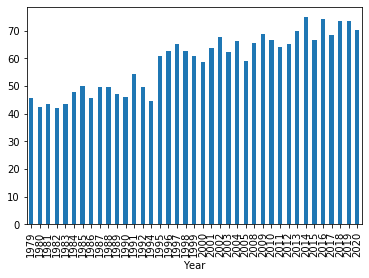

In [25]:
#Average length over time
years.set_index("Year")["Minutes_mean"].plot(kind='bar')

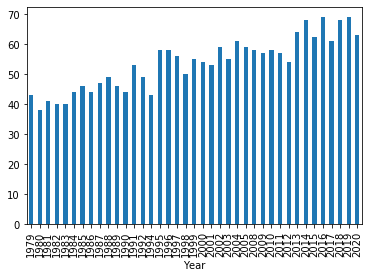

In [29]:
#Average length over time
years.set_index("Year")["Minutes_min"].plot(kind='bar')

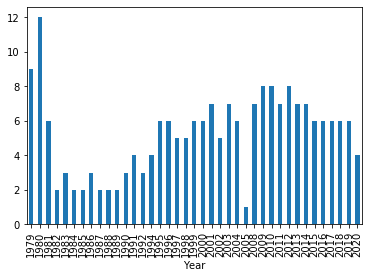

In [26]:
#number of episodes over time
years.set_index("Year")["ID_count"].plot(kind='bar')

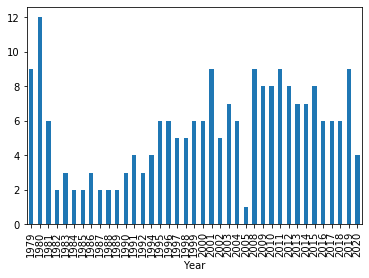

In [36]:
#number of episodes over time
years.set_index("Year")["Parts_sum"].plot(kind='bar')

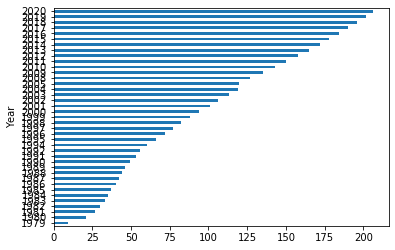

In [37]:
#number of episodes over time
years.set_index("Year")["ID_last"].plot(kind='barh')

# rubbish code